### Constructing a combined dataset from multiple sources
Something here.

In [1]:
import pandas as pd
import numpy as np
import time
import sys
import os
import gensim
import warnings
import itertools
import multiprocessing as mp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Other modules imported from the local package.
sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle
from oats.utils.utils import function_wrapper, to_hms

# Setting some options to make notebook output clearer.
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.multi_sparse', False)
warnings.simplefilter('ignore')

In [2]:
from oats.datasets.dataset import Dataset

# Put together a complete dataset from files that have been formatted correctly in the other notebooks.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_text.csv", lineterminator="\n"))
#dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_annot_go.csv", lineterminator="\n"))
#dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_annot_po.csv", lineterminator="\n"))
dataset.collapse_by_first_gene_name()
dataset.filter_has_description()
#dataset.filter_has_annotation()
dataset.describe()

Number of rows in the dataframe: 5303
Number of unique IDs:            5303
Number of unique descriptions:   3085
Number of unique gene name sets: 5303
Number of species represented:   1


### Looking at what pathways or groups are represented by genes in that dataset
something more here

In [3]:
from oats.datasets.groupings import Groupings
from oats.utils.utils import merge_list_dicts


genes = dataset.get_gene_dictionary()

# Create/read in the different objects for organizing gene groupings.
groupings_kegg = load_from_pickle(path="../data/pickles/kegg_pathways.pickle")
groupings_pmn = load_from_pickle(path="../data/pickles/pmn_pathways.pickle")
groupings_subset = load_from_pickle(path="../data/pickles/lloyd_subsets.pickle")
groupings_class = load_from_pickle(path="../data/pickles/lloyd_classes.pickle")

# Get mappings between object IDs and pathways IDs and the reverse.
id_to_pathway_ids = merge_list_dicts(
    groupings_kegg.get_forward_dict(genes),
    groupings_pmn.get_forward_dict(genes),
    groupings_subset.get_forward_dict(genes))

# Show some mappings between IDs and groups where the ID belongs to atleast one.
total = len(id_to_pathway_ids.keys())
has_mapping = len([k for (k,v) in id_to_pathway_ids.items() if len(v)>0])
print("Of the {} genes in the dataset, {} are mapped to atleast one pathway.".format(total, has_mapping))
for k,v in [(k,v) for (k,v) in id_to_pathway_ids.items() if len(v)>0][:25]:
    print("{0:<8}{1:<}".format(k," ".join(v)[:80]))

Of the 5303 genes in the dataset, 663 are mapped to atleast one pathway.
17      PWY-5080 PWY-7036
19      PWY-6
20      PWY-6733
22      PWY-7270 ETHYL-PWY
23      PWY-181
25      PWY-5667 TRIGLSYN-PWY
32      PWY-6295 PWY-6733 PWY-84
37      PWY-282
45      PWY-6898 PWY-7356 PWY-6908
50      LEU-DEG2-PWY
56      PWY-622
58      HEME-BIOSYNTHESIS-II CHLOROPHYLL-SYN
62      PWY-6745
69      PWY-581 PWYDQC-4
70      PWY-5080
79      PWY-6446 PWY-6444 PWY-3181
81      PWY-5136
92      PWY-6363 PWY-6364
93      PWY-5272 PWY-1782 PWY-1741
94      PWY-6363 PWY-6364
104     PWY-5136 PWY-6837
106     PWY-6773
107     PWY-5129
108     PWY-5667 TRIGLSYN-PWY
112     PWY-6475


In [4]:
# TODO why are their duplicates in the lists which are values in that dict????
# Check why duplicates aren't being removed there.




# Get a mapping that goes the other way, from pathway IDs to object IDs.
pathway_id_to_ids = merge_list_dicts(
    groupings_kegg.get_reverse_dict(genes),
    groupings_pmn.get_reverse_dict(genes),
    groupings_subset.get_reverse_dict(genes))

pathway_id_to_ids = groupings_pmn.get_reverse_dict(genes)

# Show some mappings between group IDs and IDs where the group has atleast two gene in the dataset.
total = len(pathway_id_to_ids.keys())
has_mapping = len([k for (k,v) in pathway_id_to_ids.items() if len(v)>1])
print("Of the {} groups in the dataset, {} are mapped to atleast one gene.".format(total, has_mapping))
for k,v in [(k,v) for (k,v) in pathway_id_to_ids.items() if len(v)>1][:20]:
    print("{0:<30}{1:<}".format(k[:27]," ".join([str(x) for x in v][:15])))

Of the 422 groups in the dataset, 295 are mapped to atleast one gene.
PWY-5080                      17 70 754 1142 1461 2056 2447 2624 2628 2848 3181
PWY-7036                      17 754 1573 2056 2447 2539 2628 2848 3181
PWY-6733                      20 32 328 523 671 695 724 875 969 1472 1711 1718 2260 2455 2617
PWY-7270                      22 1724 1979 2132 2243 2273 2506 2675 3524
ETHYL-PWY                     22 197 1724 1979 2132 2243 2273 2506 2675 3524
PWY-181                       23 367 746 916 2678
PWY-5667                      25 108 450 700 1641 2086 2121 2170 2561
TRIGLSYN-PWY                  25 108 450 700 1047 1641 2086 2170 2561
PWY-6295                      32 2635
PWY-84                        32 2635
PWY-282                       37 2617 3395
PWY-7356                      45 361 2545 3098
PWY-6908                      45 361 2545
LEU-DEG2-PWY                  50 173 174 534 790 1150 1668 1722 1765 1931 1978 2620 2822 3084
PWY-622                       56 194 459 1

In [5]:
# How many occurences are there of a specific gene pair sharing atleast one pathway?
unique_gene_id_pairs = set()
for gene_id_list in pathway_id_to_ids.values():
    gene_id_pairs = list(itertools.combinations(gene_id_list, 2))
    sorted_gene_id_pairs = [tuple(sorted(x)) for x in gene_id_pairs]
    unique_gene_id_pairs.update(sorted_gene_id_pairs)
print(len(unique_gene_id_pairs))

2548


1
19


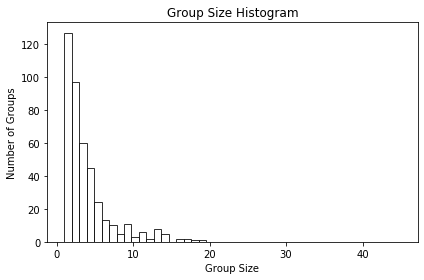

In [6]:
# What about the distributions of membership for each of the groupings?
x = [len(v) for v in pathway_id_to_ids.values()]
print(min(x))
print(max(x))
plt.hist(x, bins=45, range=(1,45), density=False, alpha=0.8, histtype='bar', color='white', edgecolor='black')
plt.title("Group Size Histogram")
plt.xlabel("Group Size")
plt.ylabel("Number of Groups")
plt.tight_layout()

### Subsetting the dataset and looking at what information is present
something more here

In [7]:
# Subset the dataset to retain only the genes that are mapped to atleast one group.
dataset.filter_with_ids([k for k,v in id_to_pathway_ids.items() if len(v)>0])
dataset.describe()

Number of rows in the dataframe: 663
Number of unique IDs:            663
Number of unique descriptions:   589
Number of unique gene name sets: 663
Number of species represented:   1


In [8]:
# Get mapping from IDs to gene objects.
genes = dataset.get_gene_dictionary()
for k,v in list(genes.items())[:10]:
    print("{0:<8}{1:<}".format(k," ".join(v.names)))

0       AT1G01120
1       AT1G01220
2       AT1G01280
3       AT1G01480
4       AT1G01510
5       AT1G01610
6       AT1G02050
7       AT1G02205
8       AT1G02880
9       AT1G03090


In [9]:
# Get a mapping from IDs to annotations (lists of ontology terms).
annotations = dataset.get_annotations_dictionary()
for k,v in list(annotations.items())[:10]:
    print("{0:<8}{1:<}".format(k," ".join(v)[:88])) 

0       
1       
2       
3       
4       
5       
6       
7       
8       
9       


In [10]:
from oats.nlp.preprocess import get_clean_description

# Get a mapping from IDs to text descriptions.
descriptions = dataset.get_description_dictionary()
descriptions = {i:get_clean_description(d) for (i,d) in descriptions.items()}
for k,v in list(descriptions.items())[:10]:
    print("{0:<8}{1:<}".format(k,v[:80]))

0       thin stems sensitive to low humidity
1       fkgp1 mutants have about 40 times more lfucose than wild type arabidopsis plants
2       slightly longer inflorescences an extended period of blooming a reduced number o
3       enhanced hypocotyl length in lightgrown seedlings enlarged cotyledons increased 
4       lacks trichomes on stems and leaves some rudimentary trichomes in leaf margins n
5       this double knockout mutant has a 6070 overall decrease in cutin monomer content
6       abnormal exine patterning pollen has a more extensively covered surface with bro
7       very bright green stems and siliques complete absence of lobed plates and tubesh
8       the attpk1ko single mutant does not have any obvious aberrant phenotypes but the
9       seeds have high levels of free branchedchain amino acids ile leu and val also hi


### Building the pairwise similarity matrices
Something description here about how this is done.

In [11]:
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import get_edgelist_with_doc2vec
from oats.graphs.pairwise import get_edgelist_with_bagofwords
from oats.graphs.pairwise import get_edgelist_with_setofwords
from oats.graphs.pairwise import get_edgelist_with_annotations
from oats.graphs.pairwise import merge_edgelists, subset_edgelist_with_ids



# Setup some of the preliminary ontology and document embeddings stuff.
merged_ontology_file = "../ontologies/mo.obo"
doc2vec_model_file = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_file)
mo = Ontology(merged_ontology_file)
annotations = dataset.get_annotations_dictionary()

In [12]:
# Creating one edge list for each method, then merging them into a single dataframe.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = get_edgelist_with_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = get_edgelist_with_bagofwords(descriptions)             
name_to_df_mapping["setofwords"] = get_edgelist_with_setofwords(descriptions)
#name_to_df_mapping["setofterms"] = get_edgelist_with_annotations(annotations, mo)

df = merge_edgelists(name_to_df_mapping, default_value=0.000)
print(df.head(20))
print(df.shape)

    from  to   doc2vec  bagofwords  setofwords
0      0   0  0.000000    0.000000    0.000000
1      0   1  0.487537    0.973022    0.978723
2      0   2  0.421716    0.949363    0.973684
3      0   3  0.436324    0.899581    1.000000
4      0   4  0.570359    0.901715    0.993506
5      0   5  0.432823    0.947729    0.977273
6      0   6  0.379772    1.000000    1.000000
7      0   7  0.271333    0.756568    0.878788
8      0   8  0.575590    0.964331    0.982759
9      0   9  0.521403    0.944444    0.960000
10     0  10  0.569148    0.938396    0.993464
11     0  11  0.412088    1.000000    1.000000
12     0  12  0.462024    0.894591    1.000000
13     0  13  0.350682    0.816691    1.000000
14     0  14  0.384398    1.000000    1.000000
15     0  15  0.550912    1.000000    1.000000
16     0  16  0.392067    1.000000    1.000000
17     0  17  0.532064    0.864518    1.000000
18     0  18  0.447545    0.914408    1.000000
19     0  19  0.555802    0.944315    1.000000
(220116, 5)


In [13]:
# What do the similarity distributions look like for each of the methods of assessing what the value
# of the edges between the nodes is?
# Make sure that all are either similarity of distance functions but not a mixture of both.
# Look into ways that these could be standardized for using the same metric to compare each.

In [14]:
from oats.datasets.string import Interactions

inter = Interactions("/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt", genes)

AttributeError: 'DataFrame' object has no attribute 'protein1'

In [ ]:
df["interact"] = np.vectorize(inter.check_interaction)(df["from"], df["to"])
print(df)
print(pd.unique(df["interact"]))

In [ ]:
print(df.dtypes)

### Kolmogorov-Smirnov Test 
Something else about why this test is being run here and what we can potentially conclude from it, or what the result is atleast suggesting.

In [ ]:
# Within group similarity stuff.
# Where do the within group similarity values fall for each metric for the groups that have lots of genes in them?
# That should be a quartile relative to each distribution?
# Or p-value saying it's higher than the mean for that distribution or something?

# Functions for evaluting graphs based on some objective functions.
from oats.objectives.functions import classification
from oats.objectives.functions import consistency_index
from oats.graphs.indexed import IndexedGraph
from oats.objectives.functions import pr

pathway_id_to_ids = groupings_kegg.get_reverse_dict(genes)


g = IndexedGraph(df=df, value="doc2vec")


# Kolmogorov-Smirnov test to compare the distributions of within-group sample and all-group sample.
from scipy.stats import ks_2samp
dist = df["doc2vec"].values
for pathway_id, id_list in pathway_id_to_ids.items():
    if len(id_list)>1:
        pairs = list(itertools.combinations(id_list, 2))
        d = [g.get_value(int(pair[0]),int(pair[1])) for pair in pairs]
        D,p_value =  ks_2samp(d,dist)
        print("{0:<22}{1:<22}{2:<12}".format(pathway_id, D, p_value))
        #print("{}{}{}".format(pathway_id, D, p_value))






### Predicting whether or not two genes share atleast one common pathway/group
What about using the similary values present in the graph to try and predict whether or not two genes are going to be sharing a pathway? What does that look like from a precision and recall standpoint? This is essentially classifying edges in the network as either joining two nodes which are genes that share a common grouping or pathway, or joining two nodes that are not.

In [ ]:
df.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df["from"].values,df["to"].values)]
#print(df.head(5))
#print(pd.unique(df["class"]))

df["new"] = 1-df["bagofwords"]

# Make sure to remove the self edges, these are not valid positive examples because we can
# already assume that they belong to the exact same groupings or pathways.
df_sub = df[df["from"] != df["to"]]


from sklearn.metrics import precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
y_true = df_sub["class"].values
y_scores = df_sub["new"].values


# Subsetting and seeing if things improve.
pos_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==1]
neg_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==0]
max_pos_samples = 600000
max_neg_samples = 1000
pos_tuples = pos_tuples[:max_pos_samples]
neg_tuples = neg_tuples[:max_neg_samples]
print(len(pos_tuples))
print(len(neg_tuples))

#https://stats.stackexchange.com/questions/251175/what-is-baseline-in-precision-recall-curve
baseline = len(pos_tuples)/(len(pos_tuples)+len(neg_tuples))
print("Basline is {}".format(baseline))
                           
pos_tuples.extend(neg_tuples)
all_tuples = pos_tuples
y_true = [x[0] for x in all_tuples]
y_scores = [x[1] for x in all_tuples]
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

average_precision = average_precision_score(y_true, y_scores)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

#for i,j in zip(y_true,y_scores):
#    print(i, j)

from inspect import signature

precision, recall, _ = precision_recall_curve(y_true, y_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

area = auc(recall, precision)
print("area is",area)
print("baseline area is",baseline) # the area under teh baseline is just width (1) x height (basline).
print("ratio =", area/baseline)

# Make sure self-edges are being removed? Those are not valid positive samples.
# Are they in there?

# The precision recall curve looks like the things that are predictable are very easily predictable, and 
# everything else is impossible-ish to predict without tanking the precision.
# i.e., a big percentage of cases where two things are mapped to the same pathway is when they are just identical.
# And when they are not identical, then they are impsossible to distinguish from random pairings of genes.

### Predicting which pathway(s) each gene belong to
pathway_id_to_ids = groupings_kegg.get_reverse_dict(genes)This is for classifying nodes in the network as belonging to certain classes or not, rather than classifying edges between the nodes. There are multiple ways that this could be done. The way we used before was just a function over the average similarity to nodes that are known to belong to a specific class (leave-one-out prediction). That takes into account the edges that are in the graph itself, but not information about the node. For example, could a neural network that learns a mapping directly between an embedding as in the input and a class membership vector do any better here? The average similarity thing should be the baseline.

In [ ]:
id_to_pathway_ids = groupings_kegg.get_forward_dict(genes)
print("done getting pathways dictionary")

df.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df["from"].values,df["to"].values)]
df["new"] = 1-df["bagofwords"]
g = IndexedGraph(df=df, value="new")
print("done making the graph")
y_true, y_scores = classification(g, id_to_pathway_ids)
print("done doing the classifying")

from inspect import signature

precision, recall, _ = precision_recall_curve(y_true, y_scores)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

area = auc(recall, precision)
print("area is",area)
print("baseline area is",baseline) # the area under teh baseline is just width (1) x height (basline).
print("ratio =", area/baseline)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.25)
print(df_train.shape)
print(df_test.shape)

In [ ]:
df_train.loc[:,"class"] = [int(len(set(id_to_pathway_ids[id1]).intersection(set(id_to_pathway_ids[id2])))>0) for (id1,id2) in zip(df_train["from"].values,df_train["to"].values)]
print(df_train.head(20))
print(len(df_train[df_train["class"]==0]))
print(len(df_train[df_train["class"]==1]))

### Notes about different types of analysis for predicting membership or interactions based on text
The representative approach takes the encoding for each individual gene's associated text or annotations (bag of words, list of terms, vector embedding, etc), and then constructs a similar object for each grouping or function of interest (concatenates text of all members, takes union of the annotations, maybe throwing out low frequency things, etc, document embedding for concatenated text rather than the individual ones. Then the graph has edges between nodes which are genes and nodes which are representative of groups, and the similarity of a given gene to any group can be thresholded to see if it's a member. 

The question is is this actually different than doing the mean similarity of a node to all other nodes that members of a particular group, thing that was done in the last analysis? It's still just a measure of how similar is this thing to all the other things that are in that group. Slightly different approach but in concept it seems very similar. Does this approach have any advantages at all? It allows for taking in the actual data and annotations itself into account before the scores are given, so that low frequency terms or whatever are thrown out. More control? In the other way, all this information is masked and the only input to work with is a list of edge values from one node to a group of nodes representing a group.

The only other approach could be to learn an arbitrary function between some vector embedding representing the gene (only from doc2vec or also including terms with binary input vector or something like onto2vec?) and an output vector of size k where k is the number of groups and the values are the probability of membership in that group. Not a lot of data to train this on, maybe like 4000 or so samples in the whole dataset for arabidopsis, which is the most abundant.

In [ ]:
import pandas as pd
import numpy as np
def get_df(filename):
    #columns = ["protein1","protein2","combined_score"]
    df = pd.read_table(filename, delim_whitespace=True)
    return(df)

sdf = get_df("/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt")
print(sdf.head())
print(sdf.dtypes)

# The score columns are all ints, they are just 0 in cases where there is not valuable information.

In [ ]:
# Show this does not include all the pairwise interactions possible, it's just the ones there's data for in STRING.
# ie there are implicit negatives in this dataset.
print(len(pd.unique(sdf.protein1)))
print(len(pd.unique(sdf.protein2)))
print(len(sdf))
print(len(pd.unique(sdf.protein1))*len(pd.unique(sdf.protein1))/2)

In [ ]:
def remove_species_code(s):
    s = s.replace("3702.", "")
    s = s.replace(".1", "")
    return(s)

# Also look at this, do we need to account for display names?
# https://string-db.org/mapping_files/STRING_display_names/


def get_id_to_string_protein_dict(string_df, genes):

    id_to_string_protein_name = {}

    string_protein_names = set()
    string_protein_names.update(pd.unique(string_df.protein1))
    string_protein_names.update(pd.unique(string_df.protein2))
    string_protein_names = list(string_protein_names)
    string_protein_names = [remove_species_code(s) for s in string_protein_names]

    for (identifer, gene_obj) in genes.items():

        matches = set()
        for name in gene_obj.names:
            if name in string_protein_names:
                matches.add(name)
        matches = list(matches)
        if len(matches) == 0:
            id_to_string_protein_name[identifer] = None
        elif len(matches) == 1:
            id_to_string_protein_name[identifer] = matches[0]
        else:
            print(len(matches))
            raise KeyError("multiple matches in STRING for gene with names: {}".format(" ".join(matches)))
            
    return(id_to_string_protein_name)

#from oats.datasets.string import get_id_to_string_protein_dict
mapping = get_id_to_string_protein_dict(sdf, genes)

#for k,v in mapping.items():
#    print(k,v)


In [ ]:
def check_interaction(string_df, mapping, id1, id2):
    # String df is an indexed DF (multiindex of protein1 and protein2)
    # mapping is the same as the ones in the previous.
    # id1 and id2 are ID's of objects from the datset.
    
    id1 = mapping[id1]
    id2 = mapping[id2]
    
    try:
        return(string_df.loc[(id1,id2)]["combined_score"])
    except(KeyError, TypeError):
        pass
    try: 
        return(string_df.loc[(id2,id1)]["combined_score"])
    except(KeyError, TypeError):
        return(-1)
        #raise KeyError("no value in STRING for this pair of IDs")

        
        
    # Make the protein1 and protein2 columns the index (MultiIndex)
indexed_df = sdf.set_index(["protein1","protein2"], inplace=False)     


print(check_interaction(indexed_df, mapping, 1,2))
print(check_interaction(indexed_df, mapping, 21,2))
    
    
    
    
    
    

In [ ]:
# Testing out using this information from STRING to add columns to the created dataframe.
print(df.head(10))
a = df.head(100)
a["interaction"] = np.vectorize(check_interaction)(a["from"], a["to"])

In [ ]:
from oats.datasets.string import Interactions

inter = Interactions("/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt", genes)
print("Doen")